Importam librariile necesare in aceasta lectie.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Deoarece vom folosi un fisier care se afla in Google Drive - ne conectam la google drive in felul urmator:

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Incarcam setul nostru de date. In aceasta lectie vom lucra cu setul de deate headbrain, care contine informatii despre diferite persoane - genul, virsta, dimensiunea craniana si greutatea creierului.

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/shared/tekwill_ml_course/lesson05/headbrain.csv')
data.head()

,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


Separam: setul de date si coloana target.

In [ ]:
# Collecting X and Y
y = data['Brain Weight(grams)'].values
X = data.drop(['Brain Weight(grams)'], axis=1).values

Deoarece numerele din setul nostru de date sunt relativ mari, normalizam datele cu ajutorul MinMaxScaler de la sklearn.

In [ ]:
mm_scaler = MinMaxScaler()

In [ ]:
X = mm_scaler.fit_transform(X)
y = mm_scaler.fit_transform(y.reshape(-1,1))
X = np.insert(X, 0, 1, axis=1)


Impartim datele in date de antrenare si test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Implementam regresia liniara cu ajutorul formulei closed form solution.

In [ ]:
class NaiveLinear:
  def __call__(self, X, y):
    # return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return np.linalg.inv(X.T @ X) @ X.T @ y

Obtinem parametrii nostri theta cu ajutorul implementarii anterioare.

In [ ]:
naive_linear = NaiveLinear()
theta = naive_linear(X_train, y_train)

Masuram eroarea cu ajutorul MSE - Mean Squared Error, implementarea carei poate fi vazuta mai jos.

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_true - y_pred) ** 2).mean()

In [ ]:
cost_fun = MSE()
y_pred = X_train @ theta
cost_fun(y_train, y_pred)

0.011236296452189638

Masuram eroarea si pentru setul de test.

In [ ]:
y_pred = X_test.dot(theta)

In [ ]:
cost_fun = MSE()
cost_fun(y_test, y_pred)

0.00940743827270135

In [ ]:
# one might be interested in bringing the value of y_pred and y_test in the same "range" 
# and check how "off" are the values in real unit measures
import math
math.sqrt(cost_fun(mm_scaler.inverse_transform(y_pred), mm_scaler.inverse_transform(y_test))/y_pred.shape[0])

9.519715788493356

## Acum sa incercam optiunea doi - folosind gradient descent.

In [ ]:
# delete the columns of ones
X_train = np.delete(X_train, 0, 1)
X_test = np.delete(X_test, 0, 1)

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient
    
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.ones(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0) # equivalent to gradient @ np.ones(correct_dimensions)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [ ]:
loss = MSE()
linear = Linear(3)
y_pred = linear(X_train)
print(loss(y_pred, y_train.reshape(y_pred.shape)))
loss_gradient = loss.backward()
linear.backward(loss_gradient)
linear.update(0.1)
y_pred = linear(X_train)
print(loss(y_pred, y_train))


0.34163256209882337
0.30909985850046007


In [ ]:
# plt.plot(x, y_train, marker='x', label='underlying function')

# Take one step forward and one step backward to make sure nothing breaks, and that the loss decreases.
d = 3
loss = MSE()
linear = Linear(d)

num_epochs = 400
lr = 0.1

for epoch in range(num_epochs):
  y_pred = linear(X_train)
  loss_value = loss(y_pred, y_train.reshape(y_pred.shape))

  if epoch % 50 == 0:
    print(f'Epoch {epoch}, loss {loss_value}')
    # plt.plot(x, y_train.squeeze(), label=f'Epoch {epoch}')

  gradient_from_loss = loss.backward()
  linear.backward(gradient_from_loss)
  linear.update(lr)

# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

Epoch 0, loss 0.15688385147724382
Epoch 50, loss 0.0251798330991366
Epoch 100, loss 0.021564643209443807
Epoch 150, loss 0.018936491371530747
Epoch 200, loss 0.016978484647400028
Epoch 250, loss 0.015518399394413369
Epoch 300, loss 0.014429575978663558
Epoch 350, loss 0.013617611055584046


In [ ]:
# y_train.reshape(y_pred.shape)

In [ ]:
# y_pred

In [ ]:
y_hat = linear(X_test)
loss(y_hat, np.expand_dims(y_test, 1))

0.050096108179261016

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    return l1


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(X_train).float()
y_true_tensor = torch.tensor(y_train).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(0.5892, grad_fn=<MseLossBackward0>)


In [ ]:
def torch_fit(x, y, model, loss, lr, num_epochs):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor.reshape(y_pred_tensor.shape))
    if epoch % 100 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=300)

Epoch 0, loss 0.05610499158501625
Epoch 100, loss 0.02678338624536991
Epoch 200, loss 0.016763808205723763


In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
regr = LinearRegression() 
regr.fit(X_train, y_train)

LinearRegression()

In [ ]:
train_score = regr.score(X_train, y_train)
print("The training score of model is: ", train_score)

The training score of model is:  0.6264565800251869


In [ ]:
test_score = regr.score(X_test, y_test)
print("The score of the model on test data is:", test_score )

The score of the model on test data is: 0.7345676369778575


In [ ]:
y_pred = regr.predict(X_train)
mean_squared_error(y_train, y_pred)

0.011236296452189641

In [ ]:
y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

0.009407438272701317

## Observatie despre pregatirea datelor
Inainte de a aplica orice model de invatare automata asupra datelor noastre, s-ar putea sa fie nevoie sa intelegem cat de "curate" si "pregatite" sunt datele noastre pentru calcule. Multi algoritmi s-ar putea sa nu lucreze bine daca datele de intrare nu trec printr-o serie de "tratari" (sau modificari).

Cateva tehnici de curatare a datelor ar fi:
1. **Îndepărtarea observațiilor nedorite** - Aceasta include ștergerea valorilor duplicate/ redundante sau irelevante din setul de date. Observațiile duplicate apar cel mai frecvent în timpul colectării datelor, iar observațiile irelevante sunt cele care nu corespund de fapt problemei specifice pe care încercați să o rezolvați. 
2. **Corectarea erorilor structurale** - Erorile structurale includ greșeli de scriere în denumirea caracteristicilor, același atribut cu un nume diferit, clase etichetate greșit, adică clase separate care ar trebui să fie de fapt aceleași, sau majuscule incoerente. 
3. **Gestionarea valorilor anomalice nedorite** - Valorile anomalice pot cauza probleme cu anumite tipuri de modele. De exemplu, modelele de regresie liniară sunt mai puțin rezistente la valorile anomalice alte modele. În general, nu ar trebui să eliminăm valorile anomalice decât dacă avem un motiv legitim pentru a le elimina. Uneori, eliminarea lor îmbunătățește performanța, alteori nu. Facem asta daca credem ca măsurătorile sunt suspecte si este puțin probabil să facă parte din datele reale.
4. **Tratarea datelor lipsă** - Datele lipsă reprezintă o problemă înșelătoare în învățarea automată. Nu putem ignora sau elimina pur și simplu observația lipsă. Acestea trebuie tratate cu atenție, deoarece pot fi un indiciu pentru ceva important. Cele două modalități cele mai comune de a trata datele lipsă sunt: 
  - Eliminarea observațiilor cu valori lipsă. Faptul că valoarea lipsește poate fi informativ în sine. În plus, în lumea reală, deseori trebuie să faceți predicții pe baza unor date noi chiar dacă unele dintre caracteristici lipsesc!

  - Imputarea valorilor lipsă din observațiile anterioare.
Din nou, "lipsa" este aproape întotdeauna informativă în sine și ar trebui să spuneți algoritmului dacă o valoare a fost lipsă. Chiar dacă construiți un model pentru a imputa valorile, nu adăugați nicio informație reală. Nu faceți decât să întăriți modelele deja furnizate de alte caracteristici.


In [ ]:
import pandas as pd

data = {'feature1': [1, 1, 3, 1, 1, 'one', 3, np.NaN, 4, 7, -1], 
        'feature2': [1, 2, 5, 1, 4, 12, 3, 5, np.NaN, 2, '??']
        }
df = pd.DataFrame(data)
df.head(11)

,feature1,feature2
0,1,1
1,1,2
2,3,5
3,1,1
4,1,4
5,one,12
6,3,3
7,NaN,5
8,4,NaN
9,7,2


In [ ]:
# remove duplicates
df = df.drop_duplicates()
df.head(10)

,feature1,feature2
0,1,1
1,1,2
2,3,5
4,1,4
5,one,12
6,3,3
7,NaN,5
8,4,NaN
9,7,2
10,-1,??


In [ ]:
df['feature1'].value_counts()

1      3
3      2
one    1
4      1
7      1
-1     1
Name: feature1, dtype: int64

In [ ]:
# correcting structural errors
df[df['feature1'] == 'one'] = 1
df.head(10)

,feature1,feature2
0,1,1
1,1,2
2,3,5
4,1,4
5,1,1
6,3,3
7,NaN,5
8,4,NaN
9,7,2
10,-1,??


In [ ]:
df['feature1'] = df['feature1'].astype("float64")
df

,feature1,feature2
0,1.0,1
1,1.0,2
2,3.0,5
4,1.0,4
5,1.0,1
6,3.0,3
7,NaN,5
8,4.0,NaN
9,7.0,2
10,-1.0,??


In [ ]:
# stergem randurile cand valorile sunt NaN
df.dropna() # nota: n-am reasignat df ca sa nu pastrez acest rezultat

,feature1,feature2
0,1.0,1
1,1.0,2
2,3.0,5
4,1.0,4
5,1.0,1
6,3.0,3
9,7.0,2
10,-1.0,??


In [ ]:
# substituim valorile nan cu media din coloana pentru feature1
feature1_mean = df.feature1.mean()
df.feature1 = df.feature1.fillna(feature1_mean)
df

,feature1,feature2
0,1.000000,1
1,1.000000,2
2,3.000000,5
4,1.000000,4
5,1.000000,1
6,3.000000,3
7,2.222222,5
8,4.000000,NaN
9,7.000000,2
10,-1.000000,??


In [ ]:
df["feature2"] = pd.to_numeric(df["feature2"],errors="coerce")
df

,feature1,feature2
0,1.000000,1.0
1,1.000000,2.0
2,3.000000,5.0
4,1.000000,4.0
5,1.000000,1.0
6,3.000000,3.0
7,2.222222,5.0
8,4.000000,NaN
9,7.000000,2.0
10,-1.000000,NaN


In [ ]:
# substituim valorile nan cu media din coloana pentru feature2
feature2_mean = df.feature2.mean()
df.feature2 = df.feature2.fillna(feature2_mean)
df

,feature1,feature2
0,1.000000,1.000
1,1.000000,2.000
2,3.000000,5.000
4,1.000000,4.000
5,1.000000,1.000
6,3.000000,3.000
7,2.222222,5.000
8,4.000000,2.875
9,7.000000,2.000
10,-1.000000,2.875


**Standardizarea** (media zero și varianța)

- Scalarea este o metodă de standardizare utilă atunci când se lucrează cu date continue, la scări diferite și se utilizează un model care funcționează într-un spațiu liniar (model cu caracteristici liniare), de exemplu regresia liniară.
- Aceasta transformă datele într-o distribuție cu media 0 și varianța egală cu unitatea. Multe modele ML necesită aceste caracteristici


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled

,feature1,feature2
0,-0.585637,-1.364765
1,-0.585637,-0.636890
2,0.372678,1.546733
3,-0.585637,0.818859
4,-0.585637,-1.364765
5,0.372678,0.090984
6,0.000000,1.546733
7,0.851835,0.000000
8,2.289308,-0.636890
9,-1.543952,0.000000


In [ ]:
df_scaled.var()

feature1    1.111111
feature2    1.111111
dtype: float64

In [ ]:
df_scaled.mean()

feature1    0.000000e+00
feature2   -3.330669e-17
dtype: float64

Un exemplu a cat de utila poate fi standardizarea. Sa ne uitam la urmatorul exemplu:


In [ ]:
df_wine = pd.read_csv('/content/gdrive/MyDrive/shared/tekwill_ml_course/lesson05/wine_types.csv')
df_wine.head()

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
df_wine.describe()

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [ ]:
X = df_wine.drop(['Type'], axis=1)
y = df_wine.Type

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Entrenamiento del KNN
knn.fit(X_train,y_train)

# calculemos el score de nuestro clasificador
print(knn.score(X_test,y_test))

0.7111111111111111


Incercam sa aplicam acelasi algoritm, dar de data asta standardizam datele:

In [ ]:
# Instantiam standardizatorul 
ss = StandardScaler()

# Standardizăm datele apoi le impartim in date de train si test
X_scaled = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

print(knn.score(X_test,y_test))

0.9555555555555556


Doar standardizand datele am obtinut o acuratete cu 0.24 mai buna. Cat de cool!

Sa ne uitam acum la **Scalarea Min-Max**.
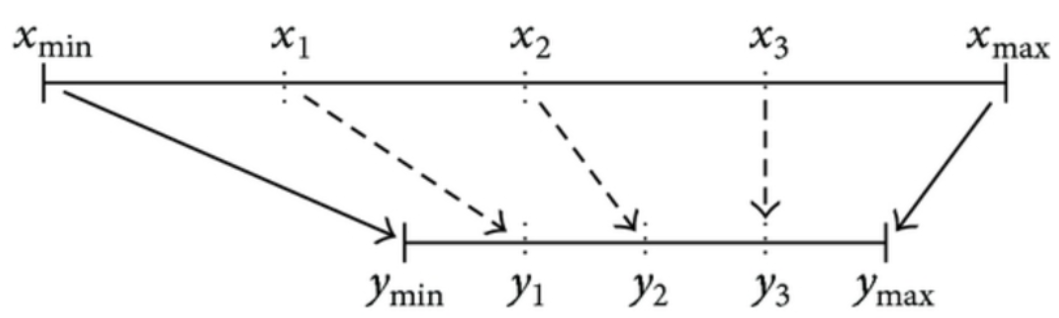

In [ ]:
from sklearn import preprocessing
mmScaler = preprocessing.MinMaxScaler()
X_mmScaler = mmScaler.fit_transform(X)
pd.DataFrame(X_mmScaler,columns=X.columns).describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.518584,0.315484,0.538244,0.458502,0.323278,0.453487,0.356386,0.437460,0.372523,0.322363,0.388170,0.491460,0.334446
std,0.213639,0.220780,0.146708,0.172142,0.155244,0.215811,0.210730,0.234818,0.180555,0.197806,0.185831,0.260070,0.224613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350658,0.170455,0.454545,0.340206,0.195652,0.262931,0.182489,0.264151,0.264984,0.165529,0.245935,0.244505,0.158702
50%,0.531579,0.222332,0.534759,0.458763,0.304348,0.474138,0.378692,0.396226,0.361199,0.290956,0.394309,0.553114,0.282097
75%,0.696711,0.462945,0.640374,0.561856,0.402174,0.627586,0.534810,0.580189,0.485804,0.419795,0.520325,0.695971,0.504280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


O alta optiune este **normalizarea logaritmica**. 
- Este utilă atunci când avem o coloană cu o variație mare.
În exemplul anterior am văzut că KNN nu a performat foarte bine, acest lucru se datorează faptului că există o variabilă cu o varianță foarte mare.

In [ ]:
import numpy as np
list_num=[30,300,3000]
list_logs=[np.log(x) for x in list_num]
print(list_num)
print(list_logs)

[30, 300, 3000]
[3.4011973816621555, 5.703782474656201, 8.006367567650246]


In [ ]:
# Să aplicăm normalizarea logaritmică pe variabila cu cea mai mare varianță și să ne uităm la rezultat.

import numpy as np

print(df_wine.Proline.var())


df_wine["Proline_log"] = np.log(df_wine.Proline)


print(df_wine.Proline_log.var())

99166.71735542428
0.17231366191842018


**One hot encoding**
- One hot encoding este încadrat în ingineria caracteristicilor, feature engineering, adică procesul de creare de noi descriptori pe baza celor existenți. Sa luam exemplu din imaginea de mai jos:
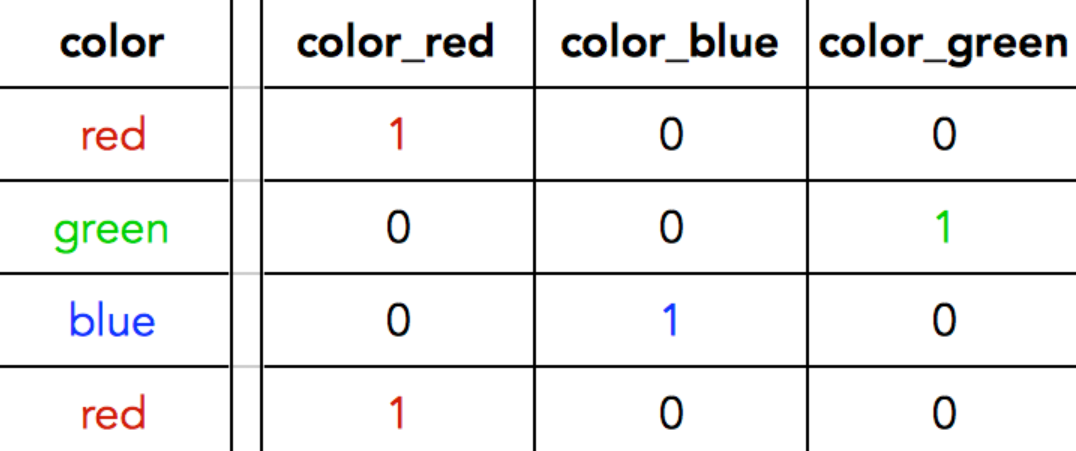

In [ ]:
data = {'feature1': [1, 1, 3, 1, 1, 1, 3, 3, 4, 7, -1], 
        'feature2': [1, 2, 5, 1, 4, 12, 3, 5, 4, 2, 3],
        'color': ['red', 'red', 'green', 'blue', 'red', 'blue', 'green', 'green', 'green', 'blue', 'blue']
        }
df = pd.DataFrame(data)
df.head(11)

,feature1,feature2,color
0,1,1,red
1,1,2,red
2,3,5,green
3,1,1,blue
4,1,4,red
5,1,12,blue
6,3,3,green
7,3,5,green
8,4,4,green
9,7,2,blue


In [ ]:
category_enc = pd.get_dummies(df["color"])
df[category_enc.columns]=category_enc
df[list(category_enc.columns)+["color"]].head(10)

,blue,green,red,color
0,0,0,1,red
1,0,0,1,red
2,0,1,0,green
3,1,0,0,blue
4,0,0,1,red
5,1,0,0,blue
6,0,1,0,green
7,0,1,0,green
8,0,1,0,green
9,1,0,0,blue


In [ ]:
df.drop(['color'], axis=1)

,feature1,feature2,blue,green,red
0,1,1,0,0,1
1,1,2,0,0,1
2,3,5,0,1,0
3,1,1,1,0,0
4,1,4,0,0,1
5,1,12,1,0,0
6,3,3,0,1,0
7,3,5,0,1,0
8,4,4,0,1,0
9,7,2,1,0,0
